# Bitcoin - Complex Graph Analysis

## Steps
1. [Parse blockchain](#Parse-blockchain-using-btcgraph.py)
2. [Data preparation (BigQuery)](#2.-Data-preparation-(BigQuery))  
    2.1. [Upload data](#2.1.-Upload-data-to-Google-Big-Query)  
    2.2. [Create new indices](#2.2.-Create-indices-for-every-address)  
    2.3. [Build edge list](#2.3.-Build-edge-list-with-timestamps-using-the-new-indices)  
    2.4. [Export data to GCS](#2.4.-Export-dataset-to-Google-Cloud-Storage)  
    2.5. [Download edge list from GCS](#2.5.-Download-edge-list-from-google-cloud-as-csv-(without-timestamp))
3. [Graph construction](#3.-Build-Graph-using-NetworKit)
4. [Analysis](#4.-Analysis)  
    4.1. The graph object  
    4.2. Connected Components  
    4.3. [](#)

***

## 1. Parse blockchain using btcgraph.py

In [5]:
%run run.py -loc data -raw -collectvalue -collectblk -upload

Starting btc graph version 0.1.0 with the following arguments:
current wd:       /home/nero/python/wu/btc/python-bitcoin-graph
startfile:        blk00000.dat 
endfile:          deactivated
starttx:          deactivated
endtx:            deactivated
endts:            deactivated
blklocation:      data         
format:           deactivated
rawedges:         activated
withts:           activated
googlebigquery:   deactivated

Initializing...
[########################################]

10:56:40  -  New BtcGraph initialized
10:56:41  -  Start building...
10:56:41  -  Block File # 0/4
10:56:41  -  Processing data/blk00000.dat
10:57:09  -  Graph has       18,216,888 bytes
10:57:09  -  Graph has               17 mb
10:57:09  -  ---  -------   ----------------------------
10:57:09  -  -->  23.2 GB   total memory
10:57:09  -  -->  16.6 GB   of memory available
10:57:09  -  -->   5.7 GB   memory used
10:57:09  -  -->   0.4 GB   memory used by this process
10:57:09  -  -->  28.1  %   of memory us

***

## 2. Data preparation (BigQuery)
   * Fetch distinct addresses 
   * Create index ID for each address
   * Create edge list from transactions with new indexes

In [9]:
import os 
from google.cloud import storage, bigquery
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'STIXGeneral'
import networkit as nk
import pandas as pd
pd.options.display.float_format = '${:,.2f}'.format
from datetime import datetime
import math
import numpy as np

credentials_path = ".gcpkey/btcgraph.json"
bucket_name      = "btcgraph"
file_name        = "btc"
target_folder    = "graph"
bq_project       = "wu-bitcoin-network"
bq_dataset       = "btc"
bq_table         = "bitcoin_transactions"

if not os.path.isdir(f'./{target_folder}'):
    os.makedirs(f'./{target_folder}')

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path

if not os.path.isdir("./pictures"):
    os.mkdir("./pictures")

### 2.2. Create indices for every address

In [7]:
# Code taken from the official docs
# https://cloud.google.com/bigquery/docs/quickstarts/quickstart-client-libraries

client = bigquery.Client()

query = """
    CREATE OR REPLACE TABLE `{0}.{1}.addresses` AS
        SELECT
          ROW_NUMBER() OVER() - 1 id, addr FROM 
          (
            SELECT DISTINCT addr FROM 
                (
                SELECT `to` AS addr FROM `{0}.{1}.{2}`
                UNION ALL
                SELECT `from` AS addr FROM `{0}.{1}.{2}` 
                )
              ORDER BY addr 
            ) 
            ORDER BY id
        """.format(bq_project,bq_dataset,bq_table)

query_job = client.query(query)
query_job.result()

### 2.3. Build edge list with timestamps using the new indices

In [4]:
try: client
except: client = bigquery.Client()
query = """
        CREATE OR REPLACE TABLE `{0}.{1}.graph_with_ts` AS
            SELECT  A.ts, B.from_id, C.to_id FROM 
            (
              (SELECT * FROM `{0}.{1}.{2}`) A
              LEFT JOIN 
              (SELECT id AS from_id, addr FROM `{0}.{1}.addresses`) B ON A.from = B.addr
              LEFT JOIN 
              (SELECT id AS to_id, addr FROM `{0}.{1}.addresses`) C ON A.to = C.addr
            )
        """.format(bq_project,bq_dataset,bq_table)

query_job = client.query(query)
query_job.result()

### 2.4. Export dataset to Google Cloud Storage

In [7]:
# Code taken from the official docs
# https://cloud.google.com/bigquery/docs/samples/bigquery-extract-table

destination_uri = "gs://{}/{}_*.csv".format(bucket_name, file_name)
dataset_ref = bigquery.DatasetReference(bq_project, bq_dataset)
table_ref = dataset_ref.table("graph_with_ts")

extract_job = client.extract_table(
    table_ref,
    destination_uri,
    # Location must match that of the source table.
    location="US",
)  # API request
extract_job.result()  # Waits for job to complete.

print(
    "Exported {}:{}.{} to {}".format(bq_project, bq_dataset, bq_table, destination_uri)
)

NameError: name 'project' is not defined

### 2.5. Download edge list from google cloud as csv (without timestamp)

In [7]:
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
file_names = map(lambda x: str(x).split(",")[1].strip(), list(bucket.list_blobs()))
for fn in file_names:
    if fn.startswith("{}_".format(file_name)):
        blob = bucket.blob(fn)
        blob.download_to_filename(target_folder + "/" + fn)
        print(f"{bucket_name}.{fn} copied to {target_folder}/{fn}")

wu-bitcoin.btc_000000000000.csv copied to graph/btc_000000000000.csv
wu-bitcoin.btc_000000000001.csv copied to graph/btc_000000000001.csv


KeyboardInterrupt: 

***

## 3. Build Graph using NetworKit

In [4]:
target_folder = "testfolder"
file_location = target_folder
files = os.listdir(file_location)
files.remove("output")
G = graph.Graph() #graphio.EdgeListReader(',', 0, directed=True).read(file_location+"/"+files[0])
print("-------")
for file in range(21):
    print(file)
    #nr = int(re.search("[1-9].[0-9]+", file).group(0))
    with open(file_location+"/"+"testf"+str(file)+".csv", "r") as csvfile:
        spamreader = csv.reader(csvfile)
        for u, v in spamreader:
            G.addEdge(int(u), int(v), addMissing=True)
            


-------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [6]:
G.numberOfEdges()

210789327

In [8]:
from networkit import *
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
counter = 2
for j in range(12,35):
    with open("testfolder/testf{}.csv".format(counter), "w") as csvfile:
        spamwriter = csv.writer(csvfile)
        
        for i in range(int("{}0000000".format(j))-10000000,int("{}0000000".format(j))):
            spamwriter.writerow([i, i+1])
    counter += 1
        

KeyboardInterrupt: 

In [25]:
G = graph.Graph()
G.addEdge??

***

## 4. Analysis

In [2]:
bq_table = "stats_invalids"
query = """
        SELECT    * 
        FROM      `{}.{}.{}`
        """.format(bq_project,bq_dataset,bq_table)

#df_inval   = pd.read_gbq(query, bq_project)

bq_table = "stats_txs_edges_per_month"
query = """
        SELECT    * 
        FROM      `{}.{}.{}`
        """.format(bq_project,bq_dataset,bq_table)

#df_   = pd.read_gbq(query, bq_project)[:-1]
#df_edges = df_[["year","month","edges"]]
#df_txs   = df_[["year","month","txs"]]


bq_table = "bitcoin_cum_node_count"

query = """
        SELECT    *
        FROM      `{}.{}.{}`
        """.format(bq_project,bq_dataset,bq_table)
#df_cnc   = pd.read_gbq(query, bq_project).sort_values("year").set_index("year").iloc[:-1]


bq_table = "bitcoin_degree_distribution_total"

query = """
        SELECT    *
        FROM      `{}.{}.{}`
        """.format(bq_project,bq_dataset,bq_table)
#df_ddt   = pd.read_gbq(query, bq_project)


bq_table = "bitcoin_degree_distribution_in_degree"

query = """
        SELECT    *
        FROM      `{}.{}.{}`
        """.format(bq_project,bq_dataset,bq_table)
#df_ddi   = pd.read_gbq(query, bq_project)


bq_table = "bitcoin_degree_distribution_out_degree"

query = """
        SELECT    *
        FROM      `{}.{}.{}`
        """.format(bq_project,bq_dataset,bq_table)
#df_ddo   = pd.read_gbq(query, bq_project)

bq_table = "stats_blk_files"
query = """
        SELECT    *
        FROM      `{}.{}.{}`
        """.format(bq_project,bq_dataset,bq_table)
#df_blkfiles = pd.read_gbq(query, bq_project)


bq_table = "coinj_all_txs_edges_per_month"

query = """
        SELECT    *
        FROM      `{}.{}.{}`
        """.format(bq_project,bq_dataset,bq_table)
#df_cj_all = pd.read_gbq(query, bq_project)[:-1]


bq_table = "entities_active_time"

query = """
        SELECT    *
        FROM      `{}.{}.{}`
        """.format(bq_project,bq_dataset,bq_table)
#df_ent_active = pd.read_gbq(query, bq_project)[:-1]



bq_table = "coinj_throughput_over_time"

query = """
        SELECT    *
        FROM      `{}.{}.{}`
        """.format(bq_project,bq_dataset,bq_table)
df_cj_throughput = pd.read_gbq(query, bq_project)[:-1]


bq_table = "usergraph_mergers_over_date"

query = """
        SELECT    *
        FROM      `{}.{}.{}`
        """.format(bq_project,bq_dataset,bq_table)
#df_mergers_over_date = pd.read_gbq(query, bq_project)[:-1]


# Add column with datetime object (from ts)
df_blkfiles["timestamp"] = list(map(lambda x: datetime.utcfromtimestamp(x).strftime("%Y/%m"), df_blkfiles["ts"]))
df_blkfiles_gr = df_blkfiles.groupby(["timestamp"]).size()[:-1]
df_blkfiles_ma_index = df_blkfiles.groupby(df_blkfiles.index // 200).mean()["blk_file_nr"]
df_blkfiles_ma_edges = df_blkfiles.groupby(df_blkfiles.index // 200).mean()["edges"]
df_blkfiles_ma_txs = df_blkfiles.groupby(df_blkfiles.index // 200).mean()["txs"]


NameError: name 'df_blkfiles' is not defined

### 4.1 General stats

In [7]:
# Table in LATEX format

print("snapshot & \#nodes & \#edges & \#txs \\\ \n\hline")
for i,j in df_cnc.iloc[:-1].iterrows():
    print("31.12."+str(i)+" &", " & ".join(["{:,.0f}".format(int(jj)) for jj in j])+" \\\ ")

snapshot & \#nodes & \#edges & \#txs \\ 
\hline
31.12.2009 & 219 & 3,628 & 152 \\ 
31.12.2010 & 117,611 & 257,312 & 75,884 \\ 
31.12.2011 & 1,959,913 & 8,489,070 & 2,607,240 \\ 
31.12.2012 & 10,360,356 & 50,119,444 & 8,515,576 \\ 
31.12.2013 & 29,940,098 & 164,461,271 & 24,609,376 \\ 
31.12.2014 & 55,142,139 & 535,406,902 & 58,796,725 \\ 
31.12.2015 & 100,424,749 & 1,102,293,611 & 115,377,800 \\ 
31.12.2016 & 182,983,931 & 1,703,651,683 & 209,846,070 \\ 
31.12.2017 & 286,991,425 & 2,762,774,783 & 353,585,596 \\ 
31.12.2018 & 368,323,195 & 3,599,394,116 & 464,992,670 \\ 
31.12.2019 & 488,039,408 & 4,697,063,711 & 595,767,289 \\ 
31.12.2020 & 600,530,518 & 5,870,848,363 & 759,465,261 \\ 


In [18]:
for i, j in df_inval.iterrows():
    print("{:<10}: {:>10,} edges  {:>10,} txs".format(j.address, j.edges, j.txs))

unknown   :    258,160 edges     221,164 txs
op_return : 64,613,605 edges  49,413,219 txs
invalid   :      9,175 edges       9,162 txs


### 4.1. Bitcoin network

In [114]:
samurai.drop_duplicates()

,year,month,sat
0,2018,7,0
1,2018,8,0
2,2018,9,0
3,2018,10,0
4,2018,11,0
5,2018,12,0
6,2019,1,0
7,2019,2,0
8,2019,3,0
9,2019,4,275000000


In [34]:
wasabi


,year,month,name,sat,moy
0,2018,7,wasabi,101778427,2018/7
1,2018,8,wasabi,1323013745,2018/8
2,2018,9,wasabi,7628887890,2018/9
3,2018,10,wasabi,42554022994,2018/10
4,2018,11,wasabi,1564226037315,2018/11
5,2018,12,wasabi,1771415888798,2018/12
6,2019,1,wasabi,2495846465181,2019/1
7,2019,2,wasabi,946021386254,2019/2
8,2019,3,wasabi,1308391257286,2019/3
10,2019,4,wasabi,1309526699389,2019/4


### 4.1.1. Transactions and edges per month

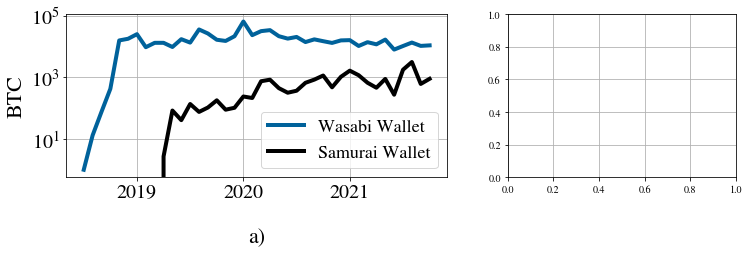

In [53]:
pd.options.mode.chained_assignment = None 
samurai = pd.DataFrame(columns=["year", "month", "sat"])
_samurai = df_cj_throughput[df_cj_throughput["name"] == "samurai"]
for i, date in df_cj_throughput[["year","month"]].iterrows():
    year = _samurai[_samurai["year"] == date["year"]]
    month = year[year["month"] == date["month"]]
    try:
        sat = int(month["sat"])/1e8
    except:
        sat = 0
    samurai = samurai.append( {"year":date["year"],"month":date["month"],"sat":sat}, ignore_index=True)
    
samurai = samurai.drop_duplicates()[:-1]       
wasabi = df_cj_throughput[df_cj_throughput["name"] == "wasabi"]
# Create figure with size 5x3.15 inches
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3),
                       gridspec_kw={
                           'width_ratios': [2.5, 1.5],
                           'height_ratios': [3]})

# Join year and month to get month-of-year `moy`
wasabi["moy"] = wasabi["year"].astype(str)  + "/" + wasabi["month"].astype(str) 

# Plot chart
axs[0].plot(wasabi["moy"],wasabi["sat"]/1e8, color="#00629b", label="Wasabi Wallet",linewidth=4)
axs[0].plot(wasabi["moy"],samurai["sat"], color="k", label="Samurai Wallet",linewidth=4)

# Customize ticks
axs[0].yaxis.get_offset_text().set_fontsize(14)
axs[0].xaxis.set_ticks(["2019/1","2020/1","2021/1"])
axs[0].set_xticklabels(["2019","2020", "2021"])
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_ylabel("BTC", fontsize=22, fontweight="ultralight")
axs[0].set_xlabel("\na)", fontsize=22, fontweight="ultralight")
axs[0].set_yscale('log')
# Legend
axs[0].legend(fontsize=18)

#Save figure and show
plt.savefig("./pictures/coinjoins.pdf")
plt.show()

In [10]:
gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 

GridSpec(1, 2, width_ratios=[3, 1])

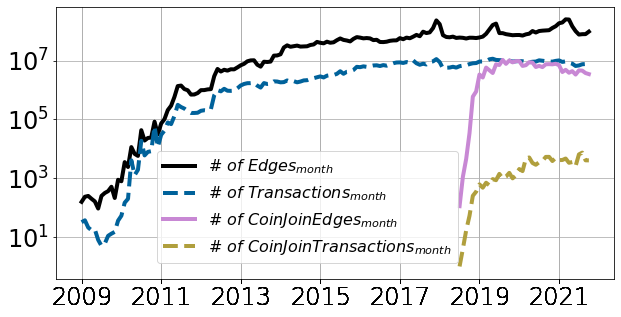

In [80]:
# Create figure with size 5x3.15 inches
plt.figure(figsize=(10, 5))

# Join year and month to get month-of-year `moy`
df_edges["moy"]  = df_edges["year"].astype(str)  + "/" + df_edges["month"].astype(str) 
df_cj_all["moy"] = df_cj_all["year"].astype(str)  + "/" + df_cj_all["month"].astype(str) 

# Plot chart
plt.plot(df_edges["moy"],df_edges["edges"], color="k", linewidth=4)
plt.plot(df_txs["moy"],df_txs["txs"], color="#00629b", linestyle='dashed', linewidth=4)
plt.plot(df_cj_all["moy"],df_cj_all["edges"], color="#c888d4", linewidth=4)
plt.plot(df_cj_all["moy"],df_cj_all["txcount"], color="#b09f3d", linestyle='dashed', linewidth=4)


# Customize ticks
ticks_position = [i+"/1" for i in df_edges["year"].astype(str) if int(i) % 2 != 0]
ticks          = [r"{}".format(tick.split("/")[0]) for tick in ticks_position]
plt.xticks(ticks_position, ticks, fontweight="ultralight", fontsize=24)
plt.yticks(fontweight="ultralight", fontsize=24)
plt.yticks(fontweight="book")
plt.gca().set_yscale('log')


# Legend
plt.legend([r"$\#\ of\ Edges_{month} \ $", r"$\#\ of\ Transactions_{month}$", 
             r"$\#\ of\ CoinJoinEdges_{month}$", r"$\#\ of\ CoinJoinTransactions_{month}$"], 
          fontsize=16,loc='best', bbox_to_anchor=(0.45, 0.5))

#Save figure and show
plt.savefig("./pictures/txs_edges_over_months_log.pdf")
plt.show()

In [305]:
df_blkfiles

,blk_file_nr,ts,edges,txs,timestamp
0,0,1303680496,962507,435110,2011/04
1,1,1308216812,1354285,319333,2011/06
2,2,1311028135,1581051,316245,2011/07
3,3,1314338057,1420577,303973,2011/08
4,4,1318423411,1455504,301414,2011/10
...,...,...,...,...,...
2788,2788,1635869326,2119485,196990,2021/11
2789,2789,1635933839,2639537,197801,2021/11
2790,2790,1635988898,2382275,209584,2021/11
2791,2791,1636050224,2076114,209004,2021/11


In [137]:
a,b = df_blkfiles.groupby(df_blkfiles.index // 200).mean()["edges"],df_blkfiles.groupby(df_blkfiles.index // 200).mean()["blk_file_nr"]

In [180]:
df_blkfiles_gr.loc[:"2017/09"].sum()

1013

In [257]:
axs[0].xaxis.

In [ ]:
axs[0].xaxis

In [12]:
df_blkfiles_max_txs

NameError: name 'df_blkfiles_max_txs' is not defined

### 4.1.1. Transactions and edges per blk file

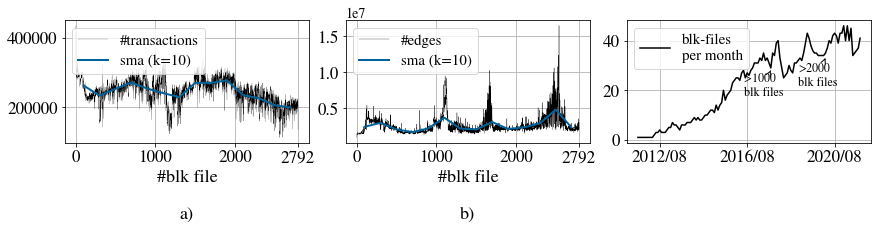

In [40]:
# Create figure with size 5x3.15 inches
f, axs = plt.subplots(1, 3,figsize=(12, 3))

# Plot chart
axs[0].plot(df_blkfiles["blk_file_nr"],df_blkfiles["txs"], color="k", linewidth = 0.2, label="#transactions")
axs[0].plot(df_blkfiles_ma_index,df_blkfiles_ma_txs, color="#00629b", linewidth = 2, label="sma (k=10)")
axs[0].xaxis.set_ticks([0,1000,2000,df_blkfiles["blk_file_nr"].iloc[-1]])
axs[0].set_xlabel("#blk file\n\na)", fontsize=18)


axs[1].plot(df_blkfiles["blk_file_nr"],df_blkfiles["edges"], color="k", linewidth = 0.3, label="#edges")
axs[1].plot(df_blkfiles_ma_index,df_blkfiles_ma_edges, color="#00629b", linewidth = 2, label="sma (k=10)")
axs[1].set_xlabel("#blk file\n\nb)", fontsize=18)
axs[1].xaxis.set_ticks([0,1000,2000,df_blkfiles["blk_file_nr"].iloc[-1]])
axs[1].yaxis.get_offset_text().set_fontsize(14)

axs[2].plot(df_blkfiles_gr.index,df_blkfiles_gr, color="k", label="blk-files\nper month")
axs[2].xaxis.set_ticks(np.arange(12, 124, 48))
axs[2].annotate(">1000 \nblk files", xy=("2017/09", 28), xycoords='data',
            xytext=("2016/06", 18), textcoords='data',size=12,
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))
axs[2].annotate(">2000\nblk files", xy=("2020/03", 33), xycoords='data',
            xytext=("2018/12", 22), textcoords='data',size=12,
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))
axs[0].legend(fontsize=15, loc="upper left")
axs[1].legend(fontsize=15)
axs[2].legend(fontsize=15)
axs[0].tick_params(axis='both', which='major', labelsize=17)
axs[1].tick_params(axis='both', which='major', labelsize=17)
axs[2].tick_params(axis='both', which='major', labelsize=17)

plt.tight_layout(pad=0)
#Save figure and show
plt.savefig("./pictures/blk_files.pdf")
plt.show()

### 4.2. Entities

In [10]:
df_ent_active[::-1]

,active_days,occurencies
3692,4069,1
3691,4056,1
3690,3932,1
3689,3924,1
3688,3912,1
...,...,...
4,4,1229155
3,3,1465791
2,2,1899936
1,1,2912166


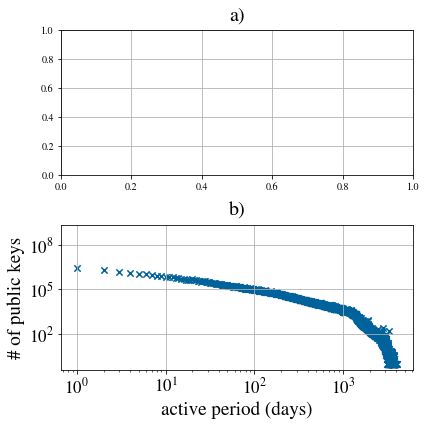

In [9]:
f, axs = plt.subplots(2, 1,figsize=(6, 6))

df_ent_active = df_ent_active[::-1]

# Plot total degree
axs[1].scatter(df_ent_active["active_days"],df_ent_active["occurencies"], s=40, color="#00629b", marker="x")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel("active period (days)", fontsize=19)
axs[1].set_ylabel("# of public keys", fontsize=19)
axs[1].tick_params(axis='both', which='major', labelsize=17)
#axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes , color="k", ls="--", label='_nolegend_')
axs[0].set_title('a)', y=1.0, pad=10, fontsize=20, fontweight="ultralight")


axs[1].set_title('b)', y=1.0, pad=10, fontsize=20, fontweight="ultralight")
plt.tight_layout(pad=1)
#Save figure and show
plt.savefig("./pictures/activity_period.pdf")
plt.show()

In [6]:
# Densification Power law
# E(t) = N(t)^a

def dense_powerlaw(cnc, cec):
    ln_x = list(map(math.log, cnc))
    ln_y = list(map(math.log, cec))

    
    mean_ln_x = np.mean(ln_x)
    mean_ln_y = np.mean(ln_y)

    xi_x = list(map(lambda x: x - mean_ln_x, ln_x))
    yi_y = list(map(lambda x: x - mean_ln_y, ln_y))        
    
    xi_x_yi_y = list(map(lambda x,y: x*y, xi_x, yi_y))
    xi_x2     = list(map(lambda x: x**2, xi_x))

    powerlaw_e = sum(xi_x_yi_y)/sum(xi_x2)
    constant   = math.exp(mean_ln_y - powerlaw_e*mean_ln_x)
    return powerlaw_e

    #print("Densification power law exponent of {:.3f} with a constant of {:.3f}".format(powerlaw_e,constant))
    #print("Equation: y = {:.3f}**{:.3f}".format(constant,powerlaw_e))
    
dense_pl = {}
for i in range(3,14):
    year = 2008 + i
    cnc, cec = df_cnc.addrs_c[1:i], df_cnc.edges_c[1:i]
    dense_pl[year] = dense_powerlaw(cnc, cec)


for year, e in dense_pl.items():
    print("{:<4}:  {:>5.4f}".format(year, e))

2011:  0.9885
2012:  1.0873
2013:  1.1165
2014:  1.1469
2015:  1.1568
2016:  1.1460
2017:  1.1335
2018:  1.1240
2019:  1.1172
2020:  1.1108
2021:  1.1073


### 4.1.2. Cumulated number of Nodes and Edges & Densification Power Law

No handles with labels found to put in legend.
No handles with labels found to put in legend.


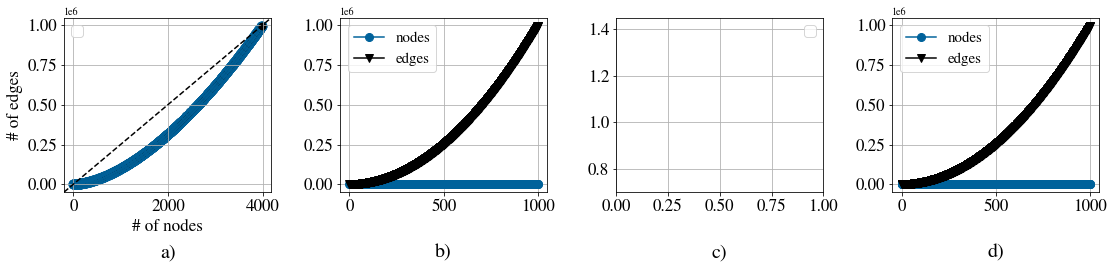

In [78]:
# Create figure with size 4x4 inches
f, axs = plt.subplots(1, 4,figsize=(16, 4))

# Plot chart
axs[0].scatter(df_cnc["addrs_c"],df_cnc["edges_c"], s=80, color="k", edgecolors="#00629b")
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes , color="k", ls="--", label='_nolegend_')

# Add month/year annoations
axs[0].annotate("09/2021", xy=(int(8.2e8), int(7.2e9)), xycoords='data',
            xytext=(int(5.6e8), int(7.1e9)), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))
axs[0].annotate("01/2016", xy=(int(1.8e8), int(1e9)), xycoords='data',
            xytext=(int(2.6e8), int(1e9)), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))

axs[0].set_xlabel('# of nodes', fontsize=17)
axs[0].set_ylabel('# of edges', fontsize=17)


# Plot chart
axs[1].plot(df_cnc.index, df_cnc["addrs_c"], color="#00629b", marker="o", markersize=8, label="nodes")
axs[1].plot(df_cnc.index, df_cnc["edges_c"], color="k", marker="v", markersize=8, label="edges")


# Plot power law coefficient over time

axs[2].plot(df_cnc.index[2:], dense_pl.values(), color="k", marker="o", markersize=8, label="densification exponent")
axs[2].set_ylim([0.7, 1.45])


# Plot chart
axs[3].plot(df_cnc.index, df_cnc["addrs_c"], color="#00629b", marker="o", markersize=8, label="nodes")
axs[3].plot(df_cnc.index, df_cnc["edges_c"], color="k", marker="v", markersize=8, label="edges")


axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
axs[2].legend(fontsize=15)
axs[3].legend(fontsize=15)

axs[0].tick_params(axis='both', which='major', labelsize=17)
axs[1].tick_params(axis='both', which='major', labelsize=17)
axs[2].tick_params(axis='both', which='major', labelsize=17)
axs[3].tick_params(axis='both', which='major', labelsize=17)

axs[0].set_title('a)', y=1.0, pad=-240, fontsize=20, fontweight="ultralight")
axs[1].set_title('b)', y=1.0, pad=-240, fontsize=20, fontweight="ultralight")
axs[2].set_title('c)', y=1.0, pad=-240, fontsize=20, fontweight="ultralight")
axs[3].set_title('d)', y=1.0, pad=-240, fontsize=20, fontweight="ultralight")


plt.tight_layout(pad=3)
#Save figure and show
#plt.savefig("./pictures/densification_over_time.pdf")
plt.show()

### 4.1.3. Degree distribution(s)

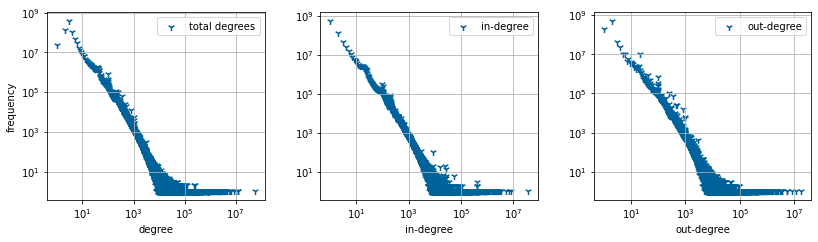

In [7]:
#
# DEGREE DISTRIBUTION 
#
# The power law coefficients are calculated using plfit.c, available
# here https://github.com/ntamas/plfit 

# Create figure with size 4x4 inches
f, axs = plt.subplots(1, 3,figsize=(12, 4))

# Plot total degree
axs[0].scatter(df_ddt["degree"],df_ddt["frequency"], s=50, color="#00629b", marker="1", label="total degrees")
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set(xlabel="degree", ylabel="frequency")
#axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes , color="k", ls="--", label='_nolegend_')

# Plot in degree
axs[1].scatter(df_ddi["degree"],df_ddi["frequency"], s=50, color="#00629b", marker="1", label="in-degree")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set(xlabel="in-degree")

# Plot out degree
axs[2].scatter(df_ddo["degree"],df_ddo["frequency"], s=50, color="#00629b", marker="1", label="out-degree")
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].legend()
axs[2].set(xlabel="out-degree")

plt.tight_layout(pad=3)
#Save figure and show
plt.savefig("./pictures/degree_distributions.pdf")
plt.show()

In [ ]:
# Create degree files 
%run bitcoin_graph/create_degree_file.py

# Calculate power law exponents using plfit.c (https://github.com/ntamas/plfit)
! ./plfit/build/src/plfit powerlaw_distribution/degree_total.txt
! ./plfit/build/src/plfit powerlaw_distribution/degree_in.txt
! ./plfit/build/src/plfit powerlaw_distribution/degree_out.txt

In [4]:
table_ref

TableReference(DatasetReference('wu-btcgraph', 'btc'), 'usergraph_test')

In [ ]:
bucket_name = "testbucketddd"
target_folder = "usergraph"
file_name = "test"

storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
file_names = map(lambda x: str(x).split(",")[1].strip(), list(bucket.list_blobs()))
#print(list(file_names))
for index, fn in enumerate(file_names):
    print(fn)
    if fn.startswith("{}".format(file_name)):
        blob = bucket.blob(fn)
        blob.download_to_filename(target_folder + "/" + fn)
        print(f"{bucket_name}.{fn} copied to {target_folder}/{fn}")
    if index >= 5:
        break

In [12]:
_df = pd.read_csv("usergraph/test000000000000.csv")
_df1 = pd.read_csv("usergraph/test000000000001.csv")

In [ ]:
#df = pd.DataFrame()
for i in range(20):
    print(i)
    df = df.append(_df)

0
1


In [21]:
df

,hashid,addrid
0,392937562,731287804
1,215345734,665447434
2,451728698,449653628
3,263949483,286499854
4,121004434,548463620
...,...,...
9776043,348100489,296529732
9776044,587630703,81748607
9776045,259213124,81748607
9776046,252981027,700151849


In [27]:
_df1[_df1["addrid"] == 2815]

,hashid,addrid
211713,147243371,2815
437801,130362142,2815
589063,352486135,2815
1014783,605749008,2815
1017020,530687643,2815
1823623,401797530,2815
4304253,277814718,2815
4704302,535301012,2815
4920890,374764875,2815
5276445,212358331,2815


In [28]:
_df

hashid    607506197
addrid    279097922
Name: 2815, dtype: int64

In [13]:
gr = _df.groupby("addrid")["hashid"].apply(list)

In [50]:
gr.loc[2815]

[69835348,
 334250108,
 286593174,
 52459000,
 195675148,
 206116092,
 212615917,
 529422539,
 250165491,
 474374422,
 124847338,
 404626068,
 622183947,
 170650287,
 320060919,
 275093596,
 553797160,
 147243371,
 130362142,
 352486135,
 605749008,
 530687643,
 401797530,
 277814718,
 535301012,
 374764875,
 212358331,
 522113123,
 209520490,
 69948563,
 437649853,
 677231541,
 94031378,
 35035328]

In [47]:
for i, row in _df1.iterrows():
    if row[1] in gr.index:
        gr.loc[row[1]].append(row[0])


In [48]:
gr

addrid
1621                                               [364978505]
1994                                                [33451130]
2532                                               [360380081]
2648                                               [285427792]
2815         [69835348, 334250108, 286593174, 52459000, 195...
                                   ...                        
897973325                                          [217220046]
897973567                     [647602243, 217078590, 43375376]
897973624                                          [605072585]
897973643                                           [12974371]
897973953    [645729761, 346480798, 455473874, 539242173, 2...
Name: hashid, Length: 5991953, dtype: object

In [11]:
df_ddi,df_ddo,df_ddt

(         degree  frequency
 0             0     175033
 1             1  575844347
 2             2  133966205
 3             3   45717564
 4             4   24541646
 ...         ...        ...
 19945   3344035          1
 19946   5128956          1
 19947   6764521          1
 19948   8580627          1
 19949  37151551          1
 
 [19950 rows x 2 columns],
          degree  frequency
 0             0   33423826
 1             1  188116290
 2             2  507343541
 3             3   39918648
 4             4   24084147
 ...         ...        ...
 20301   5148062          1
 20302   5546123          1
 20303   8254481          1
 20304  11864102          1
 20305  17954575          1
 
 [20306 rows x 2 columns],
          degree  frequency
 0             1   22514134
 1             2  141040694
 2             3  389929587
 3             4  100551048
 4             5   46502020
 ...         ...        ...
 28125   8262925          1
 28126  10675079          1
 28127  11866903  

In [20]:
df_cnc.c, df_cec.c

(4         32618
 11       176340
 12      2768616
 6       8709336
 3      24812983
 5      59004864
 7     115585183
 2     210069584
 8     353814335
 1     465223263
 9     595997733
 10    759671460
 0     883795225
 Name: c, dtype: int64,
 year
 2009         36125
 2010        357995
 2011       8700581
 2012      50626847
 2013     165403734
 2014     537007431
 2015    1103911534
 2016    1705364801
 2017    2764558510
 2018    3601248435
 2019    4698973325
 2020    5872811552
 2021    7226331456
 Name: c, dtype: int64)

In [51]:
df_cnc.addrs_c, df_cnc.edges_c

(year
 2009          152.0
 2010        75884.0
 2011      2607240.0
 2012      8515576.0
 2013     24609376.0
 2014     58796725.0
 2015    115377800.0
 2016    209846070.0
 2017    353585596.0
 2018    464992670.0
 2019    595767289.0
 2020    759465261.0
 2021    897771379.0
 2022            NaN
 Name: addrs_c, dtype: float64,
 year
 2009    3.628000e+03
 2010    2.573120e+05
 2011    8.489070e+06
 2012    5.011944e+07
 2013    1.644613e+08
 2014    5.354069e+08
 2015    1.102294e+09
 2016    1.703652e+09
 2017    2.762775e+09
 2018    3.599394e+09
 2019    4.697064e+09
 2020    5.870848e+09
 2021    7.335391e+09
 2022             NaN
 Name: edges_c, dtype: float64)

### 4.1. The graph object

In [4]:
nodes = G.numberOfNodes()
edges = G.numberOfEdges()
print(f"G has {nodes} nodes and {edges} edges")

'wu-btcgraph.json'

### 4.2. Connected components

In [2]:
cc = nk.components.ConnectedComponents(G)
cc.run()
print("number of components ", cc.numberOfComponents())

### 4.3. Degree distribution

In [5]:
dd = sorted(nk.centrality.DegreeCentrality(G).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(dd)
plt.show()

In [17]:
try:
    import powerlaw
    fit = powerlaw.Fit(dd)
except ImportError:
    print ("Module powerlaw could not be loaded")

'/home/nero/python/wu/btc/python-bitcoin-graph'

In [6]:
bucket = storage_client.bucket("wu-bitcoin")

In [9]:
blob = bucket.blob("btc.csv")
blob.download_to_filename("btcttttttttt.csv")

In [20]:
from networkit import *

In [18]:
g = graph.Graph()

In [19]:
g.numberOfEdges()

0

In [25]:
pd.DataFrame([(1,2,3),(3,4,5)], columns=["ts", "from", "to"])

,ts,from,to
0,1,2,3
1,3,4,5


In [4]:
"""
    CREATE OR REPLACE TABLE `{0}.{1}.addresses` AS
        SELECT
          ROW_NUMBER() OVER() - 1 id,
          addr
        FROM (
          SELECT
            DISTINCT addr
          FROM (
            SELECT
              `to` AS addr
            FROM
              `{0}.{1}.{2}`
            UNION ALL
            SELECT
              `from` AS addr
            FROM
              `{0}.{1}.{2}` )
          ORDER BY
            addr )
        ORDER BY
          id""".format(bq_project,bq_dataset,bq_table)

'\n    CREATE OR REPLACE TABLE `wu-btcgraph.btc.addresses` AS\n        SELECT\n          ROW_NUMBER() OVER() - 1 id,\n          addr\n        FROM (\n          SELECT\n            DISTINCT addr\n          FROM (\n            SELECT\n              `to` AS addr\n            FROM\n              `wu-btcgraph.btc.bitcoin_transactions`\n            UNION ALL\n            SELECT\n              `from` AS addr\n            FROM\n              `wu-btcgraph.btc.bitcoin_transactions` )\n          ORDER BY\n            addr )\n        ORDER BY\n          id'